In [35]:
# test the perfomance on different data samples here
import torch
import torch.backends.cudnn as cudnn
import data_loader
import utils
import global_variables as gv
import models
import argparse
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device_id = 0
torch.cuda.set_device(device_id)
wt_load = 'weights/simple_GRU_33.pth'
loader = 'val'
reload(utils)
reload(models)

<module 'models' from 'models.pyc'>

In [36]:

train_data_loader = data_loader.dataloader(gv.batch_limit,gv.train_start_index,gv.train_end_index)
val_data_loader = data_loader.dataloader(gv.batch_limit,gv.val_start_index,gv.val_end_index)
network = models.simple_GRU(3,gv.gru_size,121)
network.cuda()
# init the network with orthogonal init and gluroot.
if wt_load=="NIL":
    network.wt_init()
else:
    load = torch.load(wt_load)
    network.load_state_dict(load['model_state_dict'])
    # load wts if required.

graves_output = models.graves_output()

# for le rumours 
cudnn.benchmark = True


In [3]:
if loader == 'train':
    data_fetcher = train_data_loader.get_data()
else:
    data_fetcher = val_data_loader.get_data_single()
  

In [91]:
data,data_gt = next(data_fetcher)
cat_target = np.concatenate(data_gt[:1],axis=0)
x_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,1]).cuda())
y_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,2]).cuda())
pen_down_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,0]).cuda())

In [92]:

if loader =='train':
    output = network.forward_unlooped(data[0:1],cuda=True)
else:
    output = network.forward_unlooped(data,cuda=True)
pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr = graves_output.get_mixture_coef(output)
loss_distr,pen_loss = graves_output.loss_distr(pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, x_gt, y_gt,pen_down_gt)
predicted_action = graves_output.sample_action(pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr)
loss_l2,pen_acc = graves_output.val_loss(predicted_action, x_gt, y_gt,pen_down_gt)

In [93]:
print('loss_l2',loss_l2)
pred = predicted_action.cpu().numpy()
gt = data_gt[0]
print(pred.shape,gt.shape)

('loss_l2', tensor(0.5662, device='cuda:0'))
((841, 3), (841, 3))


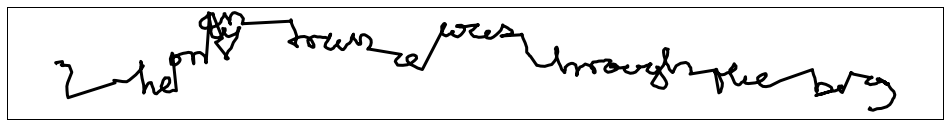

In [94]:
# the pred
#pred[:,0] = gt[:,0]
pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)
# plt.figure()
# plt.imshow(pred_image)

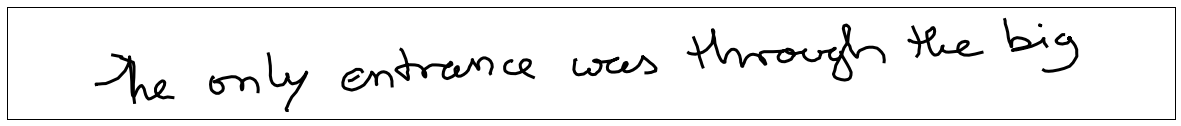

In [95]:
# the gt
gt_image = utils.plot_stroke(gt)# .transpose(2,0,1)
# plt.imshow(gt_image)

In [38]:
# self generation
output = network.forward_looped(3,700)
output.size()

torch.Size([700, 3, 3])

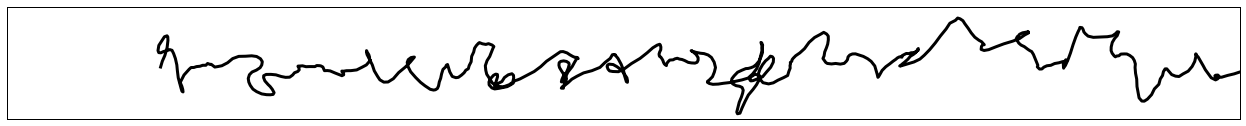

In [41]:

pred = output[:,2,:].cpu().numpy()
pred_image = utils.plot_stroke(pred)# .transpose(2,0,1)